In [8]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
# Root directory of the project
ROOT_DIR = os.path.abspath("")
#print(ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
#print(MODEL_DIR)
# Local path to trained weights file

# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)
WEIGHT_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco_0024.h5")
# Path to Shapes trained weights
#SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")
#print(SHAPES_MODEL_PATH)

In [2]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import hw3_train as hw3
config = hw3.CocoConfig()
DATA_DIR = os.path.join(ROOT_DIR, "dataset")  # TODO: enter value here

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                33
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [11]:
dataset = hw3.CocoDataset()
dataset.load_coco(DATA_DIR, "test")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
 

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Images: 100
Classes: ['BG', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Load weights
print("Loading weights ", WEIGHT_PATH)
model.load_weights(WEIGHT_PATH, by_name=True)

Loading weights  C:\Users\Administrator\Desktop\Mask_RCNN-master\logs\mask_rcnn_coco_0024.h5


image ID: coco.152 (84) http://cocodataset.org/#explore?id=152
Type: <class 'numpy.ndarray'> (1024, 1024, 3)
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 33)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
result:  (1024, 1024, 2)
gt_class_id              shape: (0,)                  min:             max:             int32
gt_bbox                  shape: (0, 4)                min:             max:             int32
gt_mask                  shape: (241, 0, 0)           min:             max:             float64


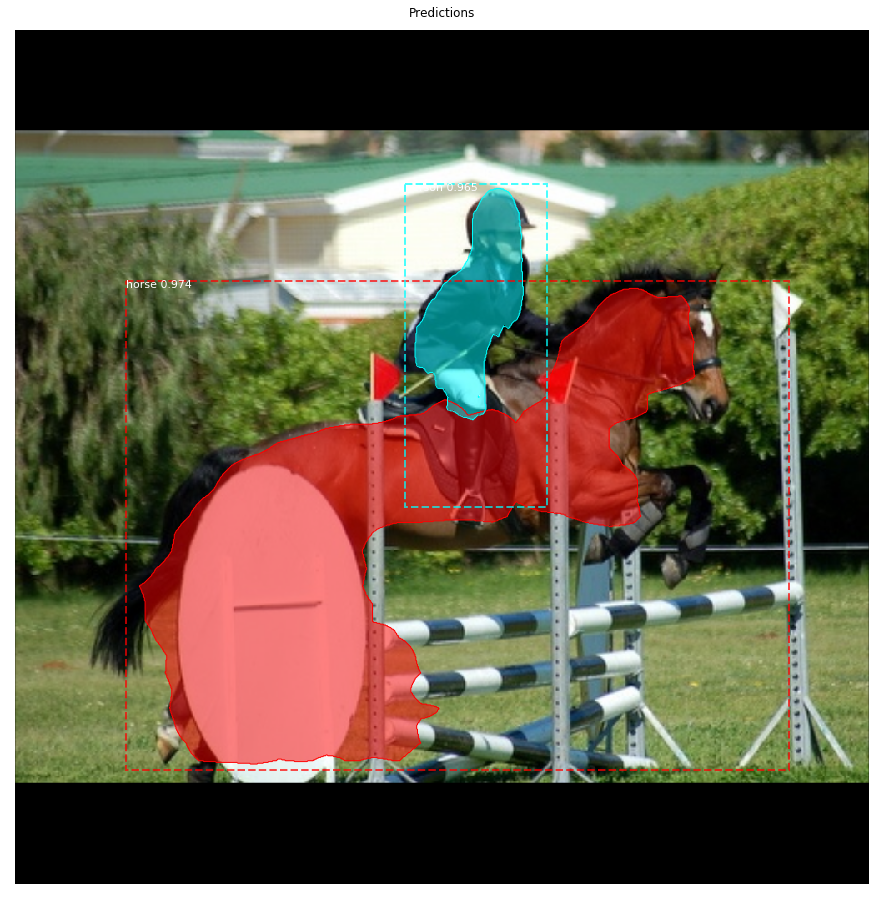

In [25]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
print("Type:",type(image), image.shape)
results = model.detect([image], verbose=1)
print("result: ",results[0]["masks"].shape)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [11]:
import numpy as np
import cv2
from itertools import groupby
from pycocotools import mask as maskutil
from torchvision import transforms
import json

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle

def getFormat(pred):
    m = pred[0]['masks']
    c = pred[0]["labels"].tolist()
    s = pred[0]["scores"].tolist()
    return m,c,s

In [17]:
transform2 = transforms.Compose([
	transforms.ToTensor(), 
	]
)

filePath = "dataset/"

cocoGt = COCO("dataset/test.json")
coco_dt = []

'''
image = cv2.imread(filePath + "test_images/" + cocoGt.imgs[914]["file_name"])
result = model.detect([image], verbose=1)
masks = result[0]["masks"]
print(masks[:,:,1].shape)
tt = masks.astype(int)
tt = binary_mask_to_rle(tt)
categories = result[0]['class_ids']
scores = result[0]["scores"]
# print(masks.shape, tt.shape)
# print(masks)

print(tt)

# image_t = transform2(image)
# masks, categories, scores = getFormat(model([image_t.to(device)]))
# tt = masks[0,0].mul(255).byte().cpu().numpy()
# tt = np.where(tt > 0.5, 1, 0)
# seg = binary_mask_to_rle(tt)
# print("mask:", tt)
# for each in tt:
#     for i in each:
#         print(i, end=" ")
#     print("")
# print("seg:", seg)
# plt.imshow(tt)

'''

for imgid in cocoGt.imgs:
    info = cocoGt.imgs[imgid]
    print(info)
    image = cv2.imread(filePath + "test_images/" + info["file_name"]) # load image
    result = model.detect([image], verbose=1)
    masks = result[0]["masks"]
    categories = result[0]['class_ids']
    scores = result[0]["scores"]
    
    # print(masks, categories, scores)
    # masks, categories, scores = getFormat(model([transform2(image).to(device)]))
    for i in range(len(scores)): # Loop all instances
        # save information of the instance in a dictionary then append on coco_dt list
        pred = {}
        pred['image_id'] = imgid # this imgid must be same as the key of test.json
        pred['category_id'] = int(categories[i])
        tt = masks[:,:,i].astype(int)
        pred['segmentation'] = binary_mask_to_rle(tt) # save binary mask to RLE, e.g. 512x512 -> rle
        pred['score'] = float(scores[i])
        coco_dt.append(pred)

with open("submission.json", "w") as f:
    json.dump(coco_dt, f)
    

    
# nn = cocoGt.imgs[17]['file_name']
# img = cv2.imread(filePath + "test_images/" + nn)
# img_cv_Tensor = transform2(img)
# print(type(img_cv_Tensor), type(dataset_test[0][0]))
# model.eval()

# pred = model([img_cv_Tensor.to(device)])
# print(pred)
# seg = binary_mask_to_rle(pred[0]["masks"][0,0].mul(255).byte().cpu().numpy())
# print(len(pred[0]["masks"]))
# seg

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
{'file_name': '2009_004886.jpg', 'id': 914, 'height': 333, 'width': 500}
Processing 1 images
image                    shape: (333, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 33)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
{'file_name': '2010_001149.jpg', 'id': 1005, 'height': 375, 'width': 500}
Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 33)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -